# Estratégia de Dual Momentum

As estretégias de "momentum" em investimentos consistem na noção que ativos com retornos positivos tendem a se manter valorizando, enquanto ativos com retornos fraco ou negativos, tendem a continuar na mesma trajetória.

No início das pesquisas academicas de finanças, a ideia de "momentum" não era bem aceita, pois imperavam noções muito estabelecidas, como a hipóstese do "Mercado Eficiente" e da imprevisibilidade de retornos futuros.

No entanto, no início da década de 70, com os descobrimento do conceito de "finanças comportamentais" e de outros *fatores* que explicavam retornos, como valor e tamanho, as estratégias de momentum ganharam força.

### Objetivo

O objetivo deste estudo é testar uma estratégia chamada de "dual momentum", que combina dois tipos de momentum *absolute momentum* e *relative momentum*. O momentum absoluto alterna entre classes de ativos distintas, por exemplo bolsa brasileira e título públicos, escolhendo a classe com maior força relativa. Já o momentum relativo, comparada dois ativos dentro da mesma classe, por exemplo bolsa brasileira e bolsa america. 

O resultado esperado é a construção de um portfolio que gere alpha em relação ao índice de referência, com menor volatilidade. A premissa do Dual Momentum é que é possível participar do mercado em momentos de bull market e evitar grandes perdas em longos momentos de bear market, investindo em ativos de renda fixa.

### Definição do Problema

Para atingir os objetivos descritos, vamos selecionar o seguintes ativos:

- IBOV (bolsa brasileira)
- S&P 500 em BRL (bolsa americana em dólar)
- IMA-B 5 (títulos públicos indexados ao IPCA com prazo de até 5 anos)
- CDI (taxa livre de risco)

A estratégia consiste em verificar qual ativo apresentou o maior retorno nos últimos 12 meses, investir nesse ativo, e rebalancear mensalmente. Para isso é necessário obter a série temporal do preço de fechamento diário desses ativos e fazer os processos necessário de processamento de dados para gerar os sinais e estimar a eficácia da estratégia. O nome de processo é **backtest**.

Esse processo em si não representa um problema de *machine learning*. No entanto, um objetivo futuro é conseguir estimar a variância e a volatilidade dos ativos para equilibrar o portfolio e reduzuir grandes drawdowns, conhecidos na literatura como "momentum crashes". Nesse próximo passo,  

In [1]:

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from utils.prices import historic_imab5, historic_sp500, historic_cdi

STAR_DATE = '2004-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

#### Importando os dados

In [2]:
IBOV = yf.Ticker('^BVSP')
ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [3]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)

In [4]:
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

       paridadeCompra  paridadeVenda  cotacaoCompra  cotacaoVenda  \
0                 1.0            1.0         2.8840        2.8940   
1                 1.0            1.0         2.8880        2.8900   
2                 1.0            1.0         2.8900        2.8930   
3                 1.0            1.0         2.8930        2.8960   
4                 1.0            1.0         2.8930        2.8950   
...               ...            ...            ...           ...   
46656             1.0            1.0         5.5575        5.5581   
46657             1.0            1.0         5.5083        5.5089   
46658             1.0            1.0         5.5034        5.5040   
46659             1.0            1.0         5.5110        5.5116   
46660             1.0            1.0         5.5201        5.5207   

              dataHoraCotacao    tipoBoletim  
0     2004-01-02 09:50:00.000       Abertura  
1     2004-01-02 10:00:00.000  Intermediário  
2     2004-01-02 10:30:00.000 

#### Obtendo os dias de negociação dos ativos de risco

Esses dias serão utilizado para normalizar as demais séries temporais com objetivo de padronizar a janela de análise e tratar valores faltantes (NAs).

In [5]:
trading_days = ibov_prices.index.to_frame(index=False, name='Date')

trading_days.tail(10)

,Date
5118,2024-09-03
5119,2024-09-04
5120,2024-09-05
5121,2024-09-06
5122,2024-09-09
5123,2024-09-10
5124,2024-09-11
5125,2024-09-12
5126,2024-09-13
5127,2024-09-16


#### Normalizando as séries temporais

In [6]:
cdi_normalized = pd.merge(trading_days, cdi, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()
imab5_normalized = pd.merge(trading_days, imab5, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()

In [7]:
relative_prices = pd.merge(ibov_prices, sp500_prices, left_index=True, right_index=True, how='left').set_axis(['IBOV', 'SP500 BRL'], axis=1)
relative_prices = relative_prices.set_axis(['IBOV', 'SP500 BRL'], axis=1)

In [8]:
print(relative_prices['IBOV'].isna().value_counts())
print(relative_prices['SP500 BRL'].isna().value_counts())

IBOV
False    5128
Name: count, dtype: int64
SP500 BRL
False    4997
True      131
Name: count, dtype: int64


Podemos observar que a série temporal de S&P 500 em reais possui 131 "dias" faltantes. Não é um número expressivo de NAs e pode ser explicado pela incompatibilidade de dias de negociação no Brasil e nos EUA, devido a feriados e outros casos.

Para tratar esses valores faltantes podemos utilizar o métodos `ffill()` do Pandas. Esse método preenche o valor NA com o valor não-nulo anterior mais próximo. Esse tratamento é satisfatório pois não representará grandes impactos em nossas análise.

In [9]:
relative_prices['SP500 BRL'] = relative_prices['SP500 BRL'].ffill()

print(relative_prices['SP500 BRL'].isna().value_counts())

SP500 BRL
False    5128
Name: count, dtype: int64


#### Tabela principal de preços

In [11]:
ativos = ['CDI', 'IMA-B 5', 'IBOV', 'SP500 BRL']

prices = pd.concat([cdi_normalized, imab5_normalized, relative_prices['IBOV'], relative_prices['SP500 BRL']], keys=ativos, join='inner', axis=1)

prices

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000,22445.0,3199.294920
2004-01-05,1.000601,1.000576,23532.0,3212.579110
2004-01-06,1.001202,1.001922,23576.0,3203.358561
2004-01-07,1.001803,1.003517,23320.0,3235.157533
2004-01-08,1.002405,1.007081,23717.0,3235.933022
...,...,...,...,...
2024-09-10,8.234794,11.287701,134320.0,30914.498318
2024-09-11,8.238027,11.298682,134677.0,31318.072170
2024-09-12,8.241263,11.290110,134029.0,31646.259779
2024-09-13,8.244499,11.302452,134882.0,31346.495743


É possível notar que alguns ativos não encontram-se normalizados, por isso, é necessário garatir que todas as séries iniciem em 1 para ter uma base de comparação justa. Após normalizar o preço dos ativos, podemos visualizar seus retornos em um gráfico de linhas.

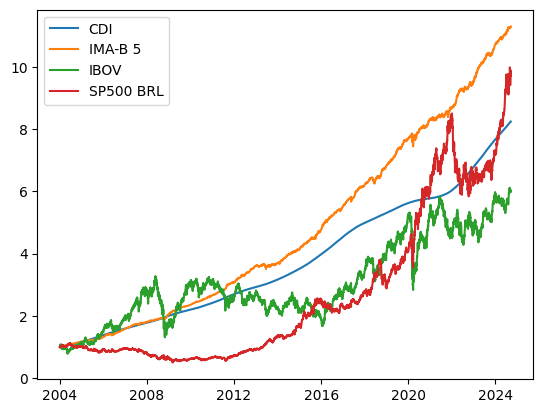

In [12]:
prices = (prices / prices.iloc[0]).dropna()

plt.plot(prices)
plt.legend(prices.columns)
plt.show()

Desde 2004, em pouco mais de 20 anos, o ativo que melhor performou foi o IMA-B 5, que é índice de título públicos atrelados ao IPCA com duração de até 5 anos. Além de apresentar a maior rentabilidade no período, também é um ativo pouco volátil, o que representa uma excelente equilíbrio entre risco e retorno.

Outro destaque é para a performance ruim do índie IBOVESPA, que apresentou um rentabilidade menor que a taxa livre de risco, o CDI.

#### Calculando o momentum dos ativos